# Transfer Learning with Fine-Tuning

In [1]:
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
# https://stackoverflow.com/questions/35869137/avoid-tensorflow-print-on-standard-error
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras

## 1. Topic

There are two different approaches for transfer learning:
1. Extract features with the healp of the pre-trained network and create a model on the extracted features.
2. Remove the fully-connected on top of the network, freeze the layers, add some trainable layers on top and train the model.

Here we are focusing on the **2nd approach** based on a pre-trained MobileNetV2 model. Other popular models that are used for transfer learning are VGG16, ResNet50 or InceptionV3.

Sources:
- https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/
- https://www.pyimagesearch.com/2019/05/27/keras-feature-extraction-on-large-datasets-with-deep-learning/
- https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
- https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
- https://keras.io/guides/transfer_learning/
- https://keras.io/api/applications/mobilenet/
- https://arxiv.org/abs/1801.04381
- https://keras.io/api/applications/

To work with images:
- https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/
- https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
- https://keras.io/api/preprocessing/image/

In [2]:
# Load image
def load_image(path, shape=(224,224)):
    """
    
    This function opens an image, reshapes it and returns the reshaped and
    rescaled image.
    
    args:
        path: the relative path to the image
        shape: the shape of the reshaped image
        
    returns:
        the batch of the reshaped image
        
    """
    img = Image.open('./' + path)
    # Create batch for network
    img_resized = img.resize([shape[0], shape[1]], resample=Image.BILINEAR) 
    img_batch = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
    return img_batch

These are examples of images that we want to classify.

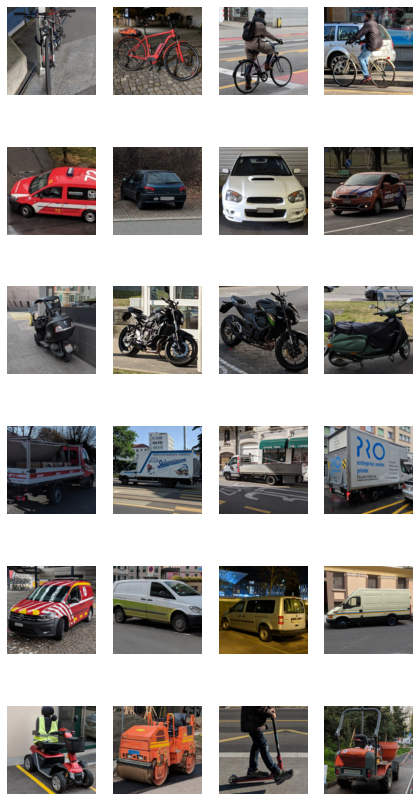

In [3]:
# Load image
categories = ['bike', 'car', 'motorcycle', 'truck', 'van', 'other']
plt.figure(figsize=(15,15))
figs_per_cat = 4 # figures per category
rows = len(categories)

for i, c in enumerate(categories):
    #print(p)
    for j in range(figs_per_cat):
        # 1, 7
        plt.subplot(rows, figs_per_cat, i*figs_per_cat+j+1)
        plt.subplots_adjust(right=0.5)
        path = 'train/' + c + '/' + c + '-' + str(j+1).zfill(4) + '.png'
        #print(path)
        img = load_image(path)
        
        #print('Batch size:', img.shape) # (1, 224, 224, 3)
        plt.imshow(img[0,:,:,:])
        plt.axis('off')

Next, we load the model.

https://keras.io/api/applications/mobilenet/

In [4]:
# load model
base_model = keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                            weights='imagenet',
                                            include_top=False)

In [5]:
# summarize the model
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## 1. Resizing and Rescaling

We will resize and rescale the image so that they fit to the model. Here is an example.

Batch size: (1, 256, 256, 3)


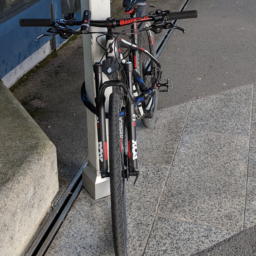

In [6]:
# Load image
img = Image.open('./train/bike/bike-0001.png')
# Create batch for network
img_batch = np.array(img, dtype=np.float32)[np.newaxis, :, :, :]/255
print('Batch size:', img_batch.shape) # (1, 256, 256, 3)
img

Batch size: (1, 224, 224, 3)


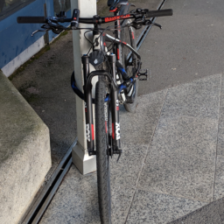

In [7]:
img_resized = img.resize([224, 224], resample=Image.BILINEAR)
img_batch_resized = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :]/255
print('Batch size:', img_batch_resized.shape) # (1, 224, 224, 3)
img_resized

## 2. The Data

To train and test the model the data are loaded and manipulated with the help of the `ImageDataGenerator()`.

- https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
- https://keras.io/api/preprocessing/image/

In [8]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
batch_size = 16
# load and iterate training dataset
train_generator = datagen.flow_from_directory(directory='train/', 
                                              target_size=(224, 224), 
                                              class_mode="categorical", 
                                              batch_size=batch_size,
                                              interpolation='bilinear')
# load and iterate validation dataset
valid_generator = datagen.flow_from_directory(directory='valid/', 
                                              target_size=(224, 224), 
                                              class_mode="categorical", 
                                              batch_size=batch_size,
                                              interpolation='bilinear')
# load and iterate test dataset
# Set shuffle = False (https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras)
test_generator = datagen.flow_from_directory(directory='test/', 
                                             target_size=(224, 224), 
                                             class_mode="categorical", 
                                             batch_size=batch_size, 
                                             interpolation='bilinear',
                                             shuffle=False)

Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


## 3. Transfer Learning

The last layer was already removed when we loaded the model. Now, we have to add new layers. See also https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975 for using `Sequential()`.

In [10]:
base_model.trainable = False

In [11]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
# Add softmax as acitvation function (https://github.com/keras-team/keras/issues/9724)
outputs = keras.layers.Dense(6, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


Next, we have to train the model. The callback is saved as well (https://stackoverflow.com/questions/38445982/how-to-log-keras-loss-output-to-a-file)

- https://keras.io/guides/transfer_learning/ 
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [13]:
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po
seed(123)
tf.random.set_seed(123)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
history_callback = model.fit_generator(train_generator,
                                       steps_per_epoch=280 // batch_size,
                                       epochs=20,
                                       validation_data=valid_generator,
                                       validation_steps=139 // batch_size)

Epoch 1/20
17/17 [==============================] - 81s 5s/step - loss: 0.7191 - binary_accuracy: 0.8617 - val_loss: 0.6902 - val_binary_accuracy: 0.9180
Epoch 2/20
17/17 [==============================] - 79s 5s/step - loss: 0.6732 - binary_accuracy: 0.9407 - val_loss: 0.6702 - val_binary_accuracy: 0.9388
Epoch 3/20
17/17 [==============================] - 78s 5s/step - loss: 0.6590 - binary_accuracy: 0.9609 - val_loss: 0.6611 - val_binary_accuracy: 0.9609
Epoch 4/20
17/17 [==============================] - 78s 5s/step - loss: 0.6484 - binary_accuracy: 0.9811 - val_loss: 0.6574 - val_binary_accuracy: 0.9648
Epoch 5/20
17/17 [==============================] - 79s 5s/step - loss: 0.6446 - binary_accuracy: 0.9848 - val_loss: 0.6559 - val_binary_accuracy: 0.9596
Epoch 6/20
17/17 [==============================] - 79s 5s/step - loss: 0.6409 - binary_accuracy: 0.9931 - val_loss: 0.6548 - val_binary_accuracy: 0.9674
Epoch 7/20
17/17 [==============================] - 81s 5s/step - loss: 0.63

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


We save the model and the history callback.

In [15]:
model.save('model')
pickle.dump(history_callback.history, open("history_callback.p", "wb"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


We load the model and the history callback. 

In [16]:
model = keras.models.load_model('model')
history_callback = pickle.load(open("history_callback.p", "rb"))

Next, we predict the classes of the test data.

In [17]:
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=0)

In [18]:
# Get classes by max element in np (as a list)
classes = list(np.argmax(pred, axis=1))
# Get filenames (set shuffle=false in generator is important)
filenames = test_generator.filenames

In [19]:
f_names = []
for i,el in enumerate(filenames):
    f_names.append(filenames[i].split("/")[0])

In [20]:
df = pd.DataFrame({'Prediction': classes, 'Truth': f_names})
df['Prediction'] = df.Prediction.astype(str)
df.replace(to_replace={'Prediction': {'0': 'bike',
                                  '1': 'car',
                                  '2': 'motorcycle',
                                  '3': 'other',
                                  '4': 'truck',
                                  '5': 'van'}}, inplace=True)
df

,Prediction,Truth
0,bike,bike
1,bike,bike
2,bike,bike
3,bike,bike
4,bike,bike
5,bike,bike
6,bike,bike
7,bike,bike
8,bike,bike
9,bike,bike


## 4. Fine-Tuning

In [21]:
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po
seed(123)
tf.random.set_seed(123)

# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
history_callback_ft = model.fit(train_generator,
                                steps_per_epoch=280 // batch_size,
                                epochs=5,
                                validation_data=valid_generator,
                                validation_steps=139 // batch_size)

Train for 17 steps, validate for 8 steps
Epoch 1/5
17/17 [==============================] - 176s 10s/step - loss: 0.6318 - binary_accuracy: 0.9987 - val_loss: 0.6498 - val_binary_accuracy: 0.9622
Epoch 2/5
17/17 [==============================] - 171s 10s/step - loss: 0.6318 - binary_accuracy: 0.9987 - val_loss: 0.6498 - val_binary_accuracy: 0.9622
Epoch 3/5
17/17 [==============================] - 171s 10s/step - loss: 0.6318 - binary_accuracy: 0.9987 - val_loss: 0.6498 - val_binary_accuracy: 0.9622
Epoch 4/5
17/17 [==============================] - 167s 10s/step - loss: 0.6311 - binary_accuracy: 1.0000 - val_loss: 0.6498 - val_binary_accuracy: 0.9648
Epoch 5/5
17/17 [==============================] - 161s 9s/step - loss: 0.6317 - binary_accuracy: 0.9987 - val_loss: 0.6498 - val_binary_accuracy: 0.9648


We save the model and the history callback ...

In [22]:
model.save('model_fine_tuned')
pickle.dump(history_callback_ft.history, open("history_callback_fine_tuned.p", "wb"))

INFO:tensorflow:Assets written to: model_fine_tuned/assets


... and load it.

In [23]:
model_ft = keras.models.load_model('model_fine_tuned')
history_callback_ft = pickle.load(open("history_callback_fine_tuned.p", "rb"))

The prediction are made with the fine-tuned model.

In [24]:
pred_ft = model_ft.predict_generator(test_generator, steps=len(test_generator), verbose=0)

In [25]:
# Get classes by max element in np (as a list)
classes_ft = list(np.argmax(pred_ft, axis=1))
# Get filenames (set shuffle=false in generator is important)
filenames = test_generator.filenames

In [26]:
f_names = []
for i,el in enumerate(filenames):
    f_names.append(filenames[i].split("/")[0])

In [27]:
df_ft = pd.DataFrame({'Prediction': classes_ft, 'Truth': f_names})
df_ft['Prediction'] = df.Prediction.astype(str)
df_ft.replace(to_replace={'Prediction': {'0': 'bike',
                                         '1': 'car',
                                         '2': 'motorcycle',
                                         '3': 'other',
                                         '4': 'truck',
                                         '5': 'van'}}, inplace=True)
df_ft

,Prediction,Truth
0,bike,bike
1,bike,bike
2,bike,bike
3,bike,bike
4,bike,bike
5,bike,bike
6,bike,bike
7,bike,bike
8,bike,bike
9,bike,bike
